In [1]:
import json
import os.path as osp
import numpy as np

def _get_list(identities):
    ret = []
    for views in identities:
        for v in views:
            for file in v:
                label = int(osp.basename(file)[:5])
                ret.append((file, label))
    return np.asarray(ret)

base_path = '../datasets/CUHK03'
with open(osp.join(base_path, 'split.json')) as f:
    split = json.load(f)
#     data = json.load(f)
#     trainval = data['trainval']
#     test_probe = data['test_probe']
#     test_gallery = data['test_gallery']
#     del data

with open(osp.join(base_path, 'meta.json')) as f:
    data = json.load(f)
#     for key, value in data.items():
#         print(key)
    shot = data['shot']
    identities = np.asarray(data['identities'])
    dabase_name = data['name']
    num_cameras = data['num_cameras']
    del data

# # extract features
# print(meta)

test_probe, test_gallery = [], []
for views in identities[split['test_probe']]:
    test_probe.append(views[:len(views) // 2])
    test_gallery.append(views[len(views) // 2:])
only_in_gallery = list(set(split['test_gallery']) - set(split['test_probe']))
test_gallery.extend(identities[only_in_gallery])
test_probe = _get_list(test_probe)
test_gallery = _get_list(test_gallery)

In [2]:
def _split(pairs):
    path = [osp.join(base_path, pair[0]) for pair in pairs]
    label = [int(pair[1]) for pair in pairs]
    return path, label

PP, PY = _split(test_probe)
GP, GY = _split(test_gallery)

unique_labels = np.unique(np.r_[PY, GY])
labels_map = {l: i for i, l in enumerate(unique_labels)}
PY = np.asarray([labels_map[l] for l in PY])
GY = np.asarray([labels_map[l] for l in GY])

In [3]:
# extract features
def extract_features(model_path, image_paths):
    import tensorflow as tf
    import importlib
    import facenet
    import scipy.misc
    
    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):
                # Load the model
                print('Loading model "%s"' % model_path)
                facenet.load_model(model_path)

                # Get input and output tensors
                images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
                phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
                embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
                image_size = images_placeholder.get_shape()
                n = len(image_paths)
                features = np.zeros((n, 128))
                images = np.zeros((n, image_size[1], image_size[2], image_size[3]))
                for i, image_path in enumerate(image_paths):
                    image = scipy.misc.imread(image_path)
                    images[i, :, :, :] = scipy.misc.imresize(image, (160, 60))
                feed_dict = { images_placeholder:images, phase_train_placeholder:True }
                features = sess.run(embeddings, feed_dict=feed_dict)
        return features

In [4]:
# pretrained_model_file = '../trained/facenet/20161101-085451/model.ckpt-100000'
# pretrained_model_file = '../trained/facenet/20161101-090329/model.ckpt-200000'
# pretrained_model_file = '../trained/facenet/20161101-115006/model.ckpt-300000'
# pretrained_model_file = '../trained/facenet/20161101-144148/model.ckpt-400000'
# pretrained_model_file = '../trained/facenet/20161101-173211/model.ckpt-500000'

# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161102-183958/model.ckpt-512'
# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161102-191257/model.ckpt-1700'
# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161103-003809/model.ckpt-200000'
# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161103-054027/model.ckpt-294800'
# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161103-105422/model.ckpt-336900'
# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk03/20161103-105422/model.ckpt-342300'

# pretrained_model_file = '../trained/nn4_small2_reid3/cuhk01/20161103-132622/model.ckpt-10000'
pretrained_model_file = '../trained/nn4_small2_reid3/cuhk01/20161103-142316/model.ckpt-20000'

PX = extract_features(pretrained_model_file, PP)
GX = extract_features(pretrained_model_file, GP)

Loading model "../trained/nn4_small2_reid3/cuhk01/20161103-142316/model.ckpt-20000"
Loading model "../trained/nn4_small2_reid3/cuhk01/20161103-142316/model.ckpt-20000"


In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from utils import *

D = pairwise_distances(GX, PX, n_jobs=-2)
C = cmc(D, GY, PY)

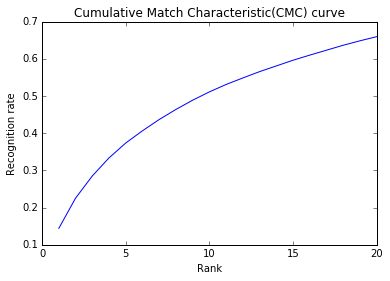

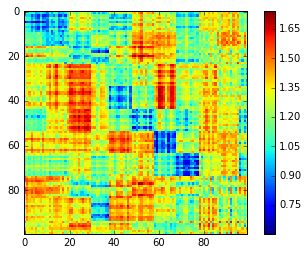

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

N = 20
plt.plot(range(1, N+1), C[:N])
plt.title('Cumulative Match Characteristic(CMC) curve')
plt.xlabel('Rank')
plt.ylabel('Recognition rate')
plt.show()

plt.figure()
plt.imshow(D[:100, :100], interpolation='nearest')
plt.colorbar()
plt.show()

In [7]:
# import scipy.misc

# for i in range(len(GY)):
#     y = GY[i]
#     j = np.argmin(D[i, :])
#     pred = PY[j]
    
#     if y != pred:
#         target = scipy.misc.imread(GP[i])
#         matched = scipy.misc.imread(PP[j])
        
#         plt.figure()
        
#         plt.subplot(121)
#         plt.axis('off')
#         plt.imshow(target)
        
#         plt.subplot(122)
#         plt.axis('off')
#         plt.imshow(matched)
        
#         plt.show()